In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import sys

sys.version

'3.12.0 (main, Oct  2 2023, 00:00:00) [GCC 13.2.1 20230918 (Red Hat 13.2.1-3)]'

# Loading complex multidimensional data (ions)

Sometimes we want to extract complex data, this is a tutorial on how to do that *imas2xarray* and [xarray](https://docs.xarray.dev)

## Defining variables

Then we must define the relations between the data. This is done via the `Variable` model.

ion_temperature is not in the default list of [variables](https://imas2xarray.readthedocs.io/en/latest/variables/), so we must define it. Note that we create an extra dimension with `*` to select all the ions.

The other variables are defined by *imas2xarray*, so we can pass them as string.

In [2]:
from imas2xarray import Variable

variables = (
    Variable(
        name='ion_temperature',
        ids='core_profiles',
        path='profiles_1d/*/ion/*/temperature',
        dims=['time', 'ion', '$rho_tor_norm'],
    ),
    't_i_ave',
    'rho_tor_norm',
    'time',
)

## Loading the data

Load the data using the `to_xarray()` function.

In [3]:
from imas2xarray import to_xarray

path = '/pfs/work/g2aho/public/imasdb/test/3/92436/1/'
ids = 'equilibrium'

ds = to_xarray(path, ids=ids, variables=variables)
ds

<xarray.Dataset>
Dimensions:          (time: 1, ion: 4, rho_tor_norm: 101)
Coordinates:
  * time             (time) float64 50.04
  * rho_tor_norm     (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
Dimensions without coordinates: ion
Data variables:
    ion_temperature  (time, ion, rho_tor_norm) float64 1.036e+04 ... 508.4
    t_i_ave          (time, rho_tor_norm) float64 1.036e+04 1.036e+04 ... 508.4

## Time Standardizing

Sometimes we have datasets with various starting times, but we want to compare them anyway
for this you can use the `standardize_time()` function, which is an in-place operation:

In [4]:
from imas2xarray import rezero_time

paths = (
    '/pfs/work/g2aho/public/imasdb/test/3/92436/1/',
    '/pfs/work/g2aho/public/imasdb/test/3/92436/2/',
    '/pfs/work/g2aho/public/imasdb/test/3/92436/3/',
)

datasets = [to_xarray(path, ids=ids, variables=variables) for path in paths]

for ds in datasets:
    rezero_time(ds, start=0.1)

## Grid and time rebasing

We can interpolate all datasets to the same reference grid and time using `standardize_grid_and_time()`.

In [5]:
from imas2xarray import standardize_grid_and_time

datasets = standardize_grid_and_time(
    datasets,
    grid_var='rho_tor_norm',
    time_var='time',
    reference_dataset=0,
)

## Data concatenation

Finally, we can concatenate along the run dimension. We set the run coordinates to the name of the data so they can be re-used later.

In [6]:
import xarray as xr

dataset = xr.concat(datasets, 'run')
dataset['run'] = [f'run_{i}' for i in range(len(paths))]

Now we have the data in a nicely structured xarray dataset.

In [7]:
dataset

<xarray.Dataset>
Dimensions:          (run: 3, time: 1, ion: 4, rho_tor_norm: 101)
Coordinates:
  * time             (time) float64 0.1
  * rho_tor_norm     (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
  * run              (run) <U5 'run_0' 'run_1' 'run_2'
Dimensions without coordinates: ion
Data variables:
    ion_temperature  (run, time, ion, rho_tor_norm) float64 1.139e+04 ... 457.5
    t_i_ave          (run, time, rho_tor_norm) float64 1.036e+04 ... 508.4

## Plotting

Now that we have standardized and rebased the grid and time coordinates, plotting and other operations on the data becomes straightforward. 

`xarray` has some built-in functionality to make plots using [matplotlib](https://matplotlib.org).

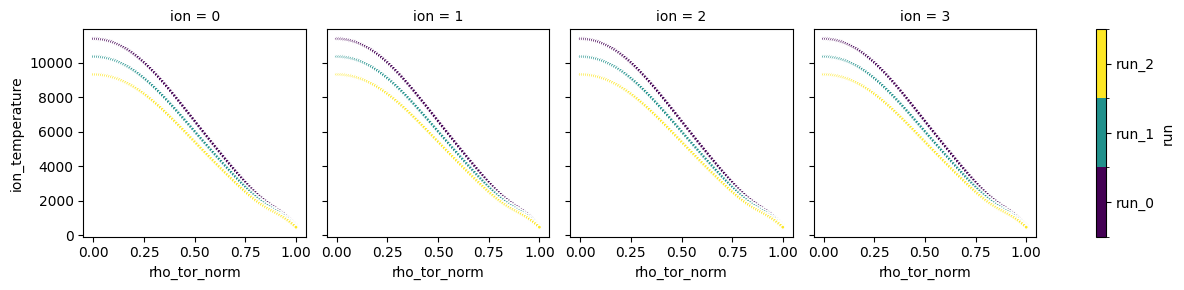

In [8]:
dataset.isel(time=0).plot.scatter(
    x='rho_tor_norm',
    y='ion_temperature',
    hue='run',
    col='ion',
    marker='.',
)

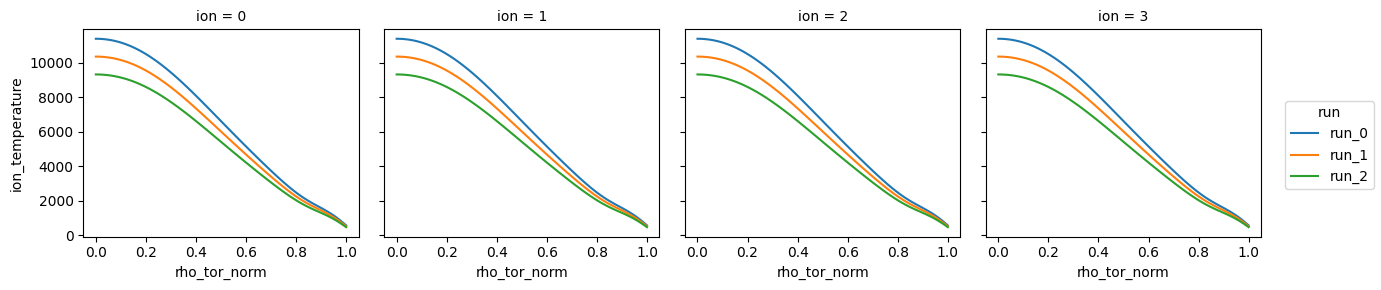

In [9]:
dataset['ion_temperature'].isel(time=0).plot.line(
    x='rho_tor_norm',
    hue='run',
    col='ion',
)

## Data reduction

To reduce the data along some dimension, we can use `dataset.reduce()`. This method takes a function as the first argument, and will apply it for each slice in the given dimension. `xarray` has some shortcuts for common operators, so `dataset.reduce(np.mean, dim='run')` is equivalent to `dataset.mean(dim='run')`.

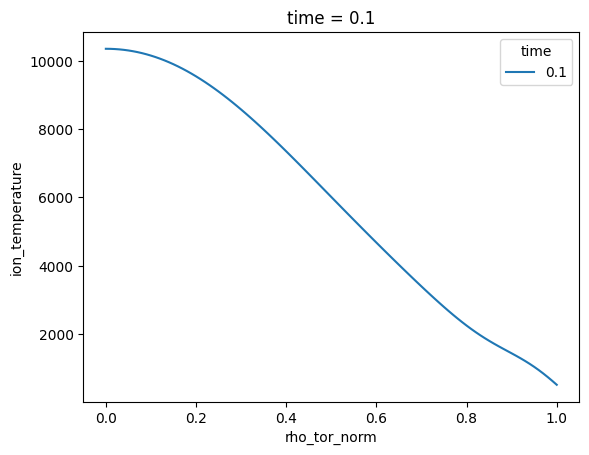

In [10]:
mean = dataset.mean(dim='run').mean(dim='ion')

mean['ion_temperature'].plot.line(
    x='rho_tor_norm',
    hue='time',
)